## Undersampler Pipeline Decision Tree with just excluding features

In [1]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)
baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})

baseball = baseball.dropna()

In [3]:
baseball.head()

,player_name,p_throws,pitch_name,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_extension,description
0,Chris Sale,L,2-Seam Fastball,95.1,2314.0,3.2655,54.4995,5.2575,1.7213,0.4271,-9.8035,-138.1130,0.1339,23.9464,31.0012,-27.0426,3.2971,1.5059,6.001,0
1,Chris Sale,L,4-Seam Fastball,96.7,2324.0,3.1728,54.3094,5.3966,0.9349,1.0015,-9.0084,-140.5865,-2.4218,14.3766,32.1373,-18.6501,3.3136,1.5730,6.191,1
2,Chris Sale,L,Slider,80.8,2521.0,3.3517,55.0820,5.1205,-1.0168,-0.1223,-3.7285,-117.3223,1.2140,-8.2088,25.0797,-33.8129,3.9119,1.7080,5.420,1
3,Chris Sale,L,4-Seam Fastball,96.2,2329.0,3.1334,54.0207,5.2136,1.3175,0.9402,-12.0533,-139.3669,-5.1407,20.1652,36.1370,-18.9205,3.5553,1.5639,6.479,1
4,Chris Sale,L,4-Seam Fastball,96.5,2437.0,3.3033,54.3597,5.0589,1.2794,0.7425,-14.0287,-139.8559,-3.3434,19.7342,30.0266,-21.9652,3.3450,1.6241,6.141,0


## Feature Creation
1. posx + movementx, posz +movementz
2. difference in the top of the zone and the position of the ball
    - any negative value will mean the ball is above the zone. 
4. difference in the position of the ball and the bottom of the zone. 
    - Any negative value will mean the ball is in the zone. 
3. compare to target

In [4]:
#baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
#baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']

#baseball['difference_top_of_zone'] = baseball['sz_top'] - baseball['position_z']
#baseball['difference_bottom_of_zone'] = baseball['position_z'] - baseball['sz_top']
#baseball['difference_side_of_plate_x'] = baseball['']
#baseball['area_of_zone'] = 17 * baseball['height_of_zone']

In [5]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description'],
      dtype='object')

In [6]:
final_df = baseball.loc[:, ['p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0',  'sz_top',
       'sz_bot',]]

final_df=pd.get_dummies(final_df, prefix = 'pitch')
final_df.head()

,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,...,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Eephus,pitch_Knuckle Curve,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,95.1,2314.0,3.2655,54.4995,5.2575,1.7213,0.4271,-9.8035,-138.1130,0.1339,...,1,0,0,0,0,0,0,0,0,0
1,96.7,2324.0,3.1728,54.3094,5.3966,0.9349,1.0015,-9.0084,-140.5865,-2.4218,...,0,1,0,0,0,0,0,0,0,0
2,80.8,2521.0,3.3517,55.0820,5.1205,-1.0168,-0.1223,-3.7285,-117.3223,1.2140,...,0,0,0,0,0,0,0,0,1,0
3,96.2,2329.0,3.1334,54.0207,5.2136,1.3175,0.9402,-12.0533,-139.3669,-5.1407,...,0,1,0,0,0,0,0,0,0,0
4,96.5,2437.0,3.3033,54.3597,5.0589,1.2794,0.7425,-14.0287,-139.8559,-3.3434,...,0,1,0,0,0,0,0,0,0,0


In [7]:
print(final_df.columns)

Index(['release_speed', 'release_spin_rate', 'release_pos_x', 'release_pos_y',
       'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'sz_top',
       'sz_bot', 'pitch_L', 'pitch_R', 'pitch_2-Seam Fastball',
       'pitch_4-Seam Fastball', 'pitch_Changeup', 'pitch_Curveball',
       'pitch_Cutter', 'pitch_Eephus', 'pitch_Knuckle Curve', 'pitch_Sinker',
       'pitch_Slider', 'pitch_Split Finger'],
      dtype='object')


## Simple Random Forest, to evaluatate new features

In [8]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(final_df,
                                                    baseball['description'], random_state = 777)
under_sampler = RandomUnderSampler(ratio = 1, random_state = 777)

tree = DecisionTreeClassifier(max_depth=4)

pipe = imblearn.pipeline.make_pipeline(under_sampler,tree)



pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(pred, y_test)



Accuracy Score: 0.5701501976284585

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.44      0.58     21552
           1       0.42      0.85      0.56     10073

    accuracy                           0.57     31625
   macro avg       0.64      0.65      0.57     31625
weighted avg       0.72      0.57      0.57     31625


 Confustion Matrix: 
 [[ 9424 12128]
 [ 1466  8607]]


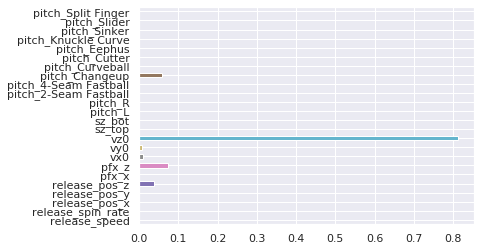

In [17]:

pd.Series(pipe[1].feature_importances_, index=X_train.columns).plot(kind = 'barh')

## USE PCA

In [18]:

cv_results_lst = []
for n_components in [3,4,5,6]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    tree = DecisionTreeClassifier(max_depth=4)
    
    pipe = Pipeline(steps = [
        ('sampler', under_sampler), #RandomUnderSampler(ratio = 1, random_state = 777)
        ('pca', pca),
        ('tree', tree)
    ])
    
    cv_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =3, return_estimator=True, return_train_score = True)

    cv_results_lst.append(cv_results)
    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(cv_results[result])}")
        print(f"{result} scores: {cv_results[result]}")
        print() 
    

    


Number of Components: 3
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.5153098361403231
train_accuracy scores: [0.49547812 0.51659315 0.53385824]

Mean test_accuracy Value: 0.5128647567415152
test_accuracy scores: [0.49479842 0.51078295 0.5330129 ]

Mean train_f1 Value: 0.4771917742629419
train_f1 scores: [0.4837906  0.47921102 0.46857369]

Mean test_f1 Value: 0.47438945304679914
test_f1 scores: [0.48516096 0.47253759 0.46546981]

Mean train_roc_auc Value: 0.5830939844000681
train_roc_auc scores: [0.58062354 0.58766671 0.58099171]

Mean test_roc_auc Value: 0.5785172712177666
test_roc_auc scores: [0.58259639 0.57443279 0.57852264]

Number of Components: 4
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.5977516986313747
train_accuracy scores: [0.59156021 0.59991462 0.60178027]

Mean test_accuracy Value: 0.5943103671699784
test_accuracy scores: [0.58684585 0.60077789 0.5953

In [19]:
cv_results_lst[3]['estimator'][0] #n_components of 6, as it performed best

Pipeline(memory=None,
         steps=[('sampler',
                 RandomUnderSampler(random_state=777, ratio=1,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=1)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=6,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=4, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                 

In [20]:
predictions = cv_results_lst[3]['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

Accuracy Score: 0.6754466403162055

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.61      0.72     21552
           1       0.49      0.82      0.62     10073

    accuracy                           0.68     31625
   macro avg       0.69      0.71      0.67     31625
weighted avg       0.76      0.68      0.69     31625


 Confustion Matrix: 
 [[13083  8469]
 [ 1795  8278]]


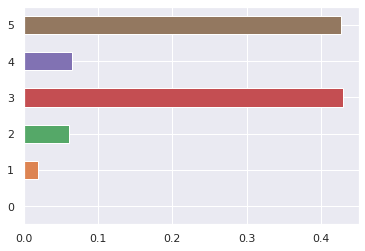

In [21]:
pd.Series(cv_results_lst[3]['estimator'][0][2].feature_importances_).plot(kind = 'barh')

In [22]:
pd.Series(cv_results_lst[3]['estimator'][0][1].explained_variance_ratio_)

0    0.998145
1    0.001302
2    0.000442
3    0.000082
4    0.000009
5    0.000004
dtype: float64